# Examples of Bayesian Analysis for Engineering Applications

Shelby Quiring for Vancouver Hardware Unconference, Sept 21st 2024

Any questions about these examples may be directed to shelbyaquiring@gmail.com.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

### Generate synthetic data to be used for the examples

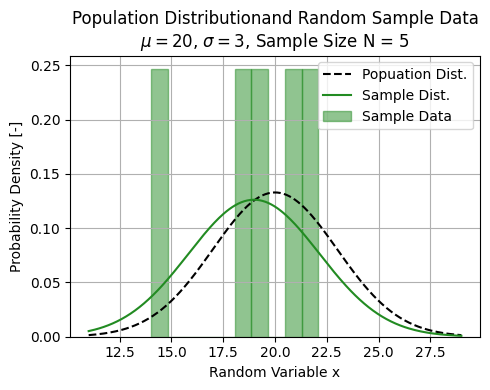

In [111]:
# Define population
mu_true = 20    # Population mean
sigma_true = 3  # Population standard deviation
pop_dist = sci.stats.norm(mu_true, sigma_true)  # Define a normal distribution with these parameters

# Take a sample
N = 5   # Sample size
rng = np.random.RandomState(seed=968)  # This line is only necessary if you want to control the random number generation seed
sample_data = pop_dist.rvs(N, random_state=rng)

# Calculate some sample statistics and generate a sample distribution with them
sample_mean = np.mean(sample_data)
sample_std = np.sqrt(np.sum((sample_data - sample_mean)**2)/(N-1))
sample_dist = sci.stats.norm(sample_mean, sample_std)  # Define a normal distribution with these parameters


# Plot the population and the sample
L = 250  # Length of the xvals array
xvals = np.linspace(mu_true - 3*sigma_true, mu_true + 3*sigma_true, L)
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(xvals, pop_dist.pdf(xvals), color='k', linestyle='--', label='Popuation Dist.')
ax.plot(xvals, sample_dist.pdf(xvals), color='forestgreen', label='Sample Dist.')
ax.hist(sample_data, color='forestgreen', alpha=0.5, edgecolor='forestgreen', density=True, label='Sample Data')

ax.set_xlabel('Random Variable x')
ax.set_ylabel('Probability Density [-]')
ax.set_title(f'Population Distribution' +  'and Random Sample Data' + f'\n$\mu = ${mu_true}, $\sigma = ${sigma_true}' + f', Sample Size N = {N}')
ax.grid('enable')
ax.legend()
fig.tight_layout()

### Example 1: Demonstrating the Likelihood and Posterior Calculations
In this example we'll keep it simple by assuming we know the standard deviation, and just do the likelihood calculation for the mean. 

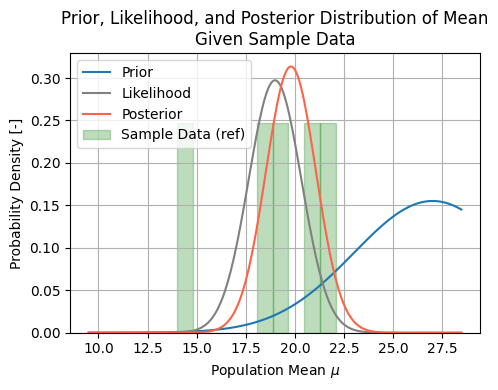

In [112]:
# Define a vector of the parameters we're searching over
mu_vector = np.linspace(sample_mean - 3*sample_std, sample_mean + 3*sample_std, L)

# Define the prior
prior = sci.stats.norm(27, 4).pdf(mu_vector)
prior /= sci.integrate.trapz(prior, mu_vector) # Normalize 

# Calculate the likelihood
# Note that for numerical reasons we do this with the log likelihood and convert back after
log_likelihood = np.zeros_like(mu_vector)
for idx, m in enumerate(mu_vector):
    probability_i = sci.stats.norm.pdf(sample_data, loc=m, scale=sigma_true)
    log_likelihood[idx] = np.sum(np.log(probability_i))

# Convert back to likelihod form log-likelihood
likelihood = np.exp(log_likelihood - np.max(log_likelihood) + 100)
likelihood /= sci.integrate.trapz(likelihood, mu_vector) # Normalize for plotting purposes

# Calculate the posterior
posterior = likelihood * prior
posterior /= sci.integrate.trapz(posterior, mu_vector) # Normalize 

# Plot the likelihood
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(mu_vector, prior, label='Prior')
ax.plot(mu_vector, likelihood, color='0.5', label='Likelihood')
ax.plot(mu_vector, posterior, color='tomato', label='Posterior')
ax.hist(sample_data, color='forestgreen', alpha=0.3, edgecolor='forestgreen', density=True, label='Sample Data (ref)')

ax.set_xlabel('Population Mean $\mu$')
ax.set_ylabel('Probability Density [-]')
ax.set_title(f'Prior, Likelihood, and Posterior Distribution of Mean\nGiven Sample Data')
ax.grid('enable')
ax.legend()
fig.tight_layout()

### Example 2: Calculating a Credible Interval and MAP estimate

MAP Mean: 19.8


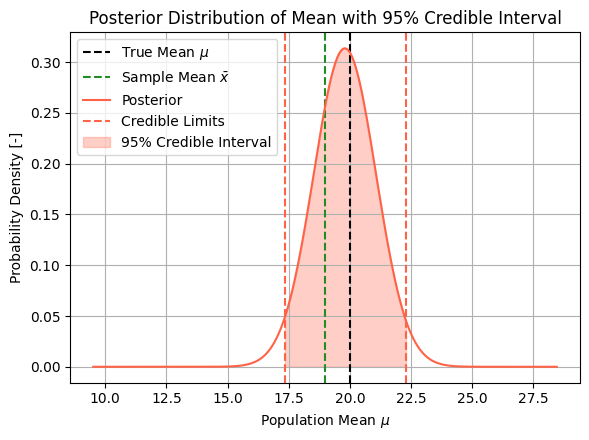

In [113]:
# Define confidence percentage
confidence_percentage = 0.95

# Take slices of the posterior to search for the limiting bounds
levels = np.linspace(np.max(posterior), 0, 1000)
d_mu = np.mean(np.diff(mu_vector))
# probs = np.zeros_like(levels)
for idx, l_ in enumerate(levels):
    if l_ == 0:
        prob = 1
    elif l_ == 1:
        prob = 0
    else:
        credible_indices = posterior > l_
        prob = np.sum(posterior[credible_indices] * d_mu) # Probability within this iso-contour
    # probs[idx] = prob
    if prob > confidence_percentage:
        break

# Define bounds
cred_lower = np.min(mu_vector[credible_indices])
cred_upper = np.max(mu_vector[credible_indices])

# Calculate the peak
max_inds = posterior == np.max(posterior)
map_mean = mu_vector[max_inds][0]
print(f'MAP Mean: {map_mean:.1f}')

# Plot the results
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.axvline(mu_true, linestyle='--', color='k', label='True Mean $\mu$')
ax.axvline(sample_mean, linestyle='--', color='forestgreen', label=r'Sample Mean $\bar{x}$')
ax.plot(mu_vector, posterior, color='tomato', label='Posterior')
ax.axvline(cred_upper, linestyle='--', color='tomato', label='Credible Limits')
ax.axvline(cred_lower, linestyle='--', color='tomato')
ax.fill_between(mu_vector[credible_indices], 0*mu_vector[credible_indices], posterior[credible_indices], color='tomato', alpha=0.3, label=f'{100*confidence_percentage:.0f}% Credible Interval')

# ax.plot(map_mean, posterior[max_inds], marker='.', markersize=15, color='blue', label='MAP $\mu$ Estimate')

ax.set_xlabel('Population Mean $\mu$')
ax.set_ylabel('Probability Density [-]')
ax.set_title(f'Posterior Distribution of Mean with {100*confidence_percentage:.0f}% Credible Interval')
ax.grid('enable')
ax.legend()
fig.tight_layout()

### Example 3: Likelihood Calculation and Credible Intervals in 2D!
Here we look at the more realistic example of not knowing what ANY parameters (mean or standard deviation) are.

MAP Mean: 19.0
MAP Std: 2.8


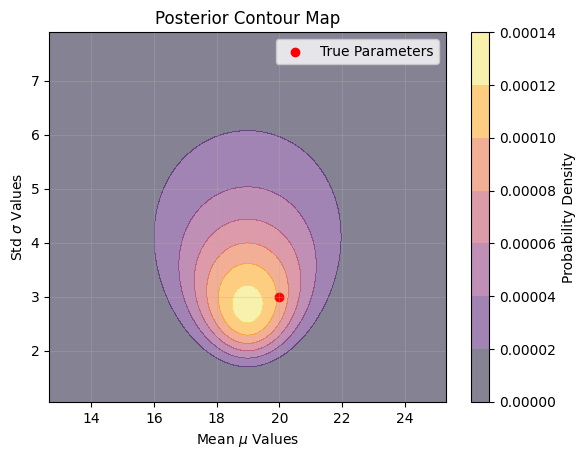

In [114]:
# Define vectors of the parameters we're searching over
mu_vector = np.linspace(sample_mean - 2*sample_std, sample_mean + 2*sample_std, L)
sigma_vector = np.linspace(sample_std/3, sample_std*2.5, L)

# Define a grid using both vectors
mu_grid, sigma_grid = np.meshgrid(mu_vector, sigma_vector)

# Define the prior
prior = np.ones_like(mu_grid)
prior /= np.sum(prior) # Normalize 

# Calculate the likelihood
# Note that for numerical reasons we do this with the log likelihood and convert back after
log_likelihood = np.zeros_like(mu_grid)
for idx, m in enumerate(mu_vector):
    for jdx, s in enumerate(sigma_vector):
        probability_i = sci.stats.norm.pdf(sample_data, loc=m, scale=s)
        log_likelihood[jdx, idx] = np.sum(np.log(probability_i))

# Convert back to likelihod form log-likelihood
likelihood = np.exp(log_likelihood - np.max(log_likelihood) + 10)
likelihood /= np.sum(likelihood) # Normalize for plotting purposes

# Calculate the posterior
posterior = likelihood * prior
posterior /= np.sum(posterior) # Normalize 

# Plot the posterior distribution as a contour map
fig, ax = plt.subplots()
cs = ax.contourf(mu_grid, sigma_grid, posterior, alpha=0.5, cmap='inferno')
ax.scatter(mu_true, sigma_true, color='r', label='True Parameters')

ax.set_xlabel('Mean $\mu$ Values')
ax.set_ylabel('Std $\sigma$ Values')
ax.set_title('Posterior Contour Map')
ax.grid('enable', alpha=0.3)
ax.legend()

cbar = fig.colorbar(cs, ax=ax)
cbar.set_label('Probability Density')

# Calculate the peak
max_inds = posterior == np.max(posterior)
map_mean = mu_grid[max_inds][0]
map_sigma = sigma_grid[max_inds][0]
print(f'MAP Mean: {map_mean:.1f}')
print(f'MAP Std: {map_sigma:.1f}')

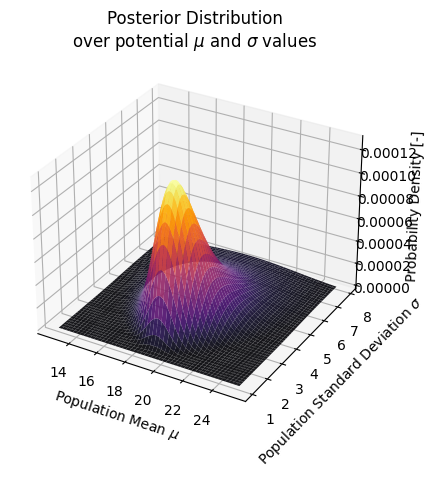

In [115]:
# Plot the posterior in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(mu_grid, sigma_grid, posterior, alpha=0.9, cmap='inferno')

ax.set_xlabel('Population Mean $\mu$')
ax.set_ylabel('Population Standard Deviation $\sigma$')
ax.set_zlabel('Probability Density [-]')
ax.set_title(f'Posterior Distribution\nover potential $\mu$ and $\sigma$ values')
ax.grid('enable')

### Example 4: Calculating the Posterior Predictive Distribution + Estimating Population Ranges
This shows how to fold the uncertainty in the population parameters into a distribution representing the measured variable. 

In [116]:
# Calculate the posterior predictive distribution
# Using the 3D posterior over mu, sigma plane
d_m = np.mean(np.diff(mu_vector))
d_s = np.mean(np.diff(sigma_vector))
dA = d_m * d_s  # Differential area
xvals_2 = xvals = np.linspace(mu_true - 5*sigma_true, mu_true + 5*sigma_true, L)
posterior_predictive_distribution = np.zeros_like(xvals)
posterior_predictive_distribution_all = np.zeros((len(mu_vector)*len(sigma_vector), L))

idx = 0
for jdx, m in enumerate(mu_vector):
    print(f'{jdx} of {L}')  # Report progress
    for kdx, s in enumerate(sigma_vector):
        posterior_predictive_distribution_all[idx, :] = sci.stats.norm(m, s).pdf(xvals) * posterior[kdx, jdx] * dA
        idx += 1

posterior_predictive_distribution = np.sum(posterior_predictive_distribution_all, axis=0)  # Sum
posterior_predictive_distribution /= np.trapz(posterior_predictive_distribution, xvals)  # Normalize

0 of 250
1 of 250
2 of 250
3 of 250
4 of 250
5 of 250
6 of 250
7 of 250
8 of 250
9 of 250
10 of 250
11 of 250
12 of 250
13 of 250
14 of 250
15 of 250
16 of 250
17 of 250
18 of 250
19 of 250
20 of 250
21 of 250
22 of 250
23 of 250
24 of 250
25 of 250
26 of 250
27 of 250
28 of 250
29 of 250
30 of 250
31 of 250
32 of 250
33 of 250
34 of 250
35 of 250
36 of 250
37 of 250
38 of 250
39 of 250
40 of 250
41 of 250
42 of 250
43 of 250
44 of 250
45 of 250
46 of 250
47 of 250
48 of 250
49 of 250
50 of 250
51 of 250
52 of 250
53 of 250
54 of 250
55 of 250
56 of 250
57 of 250
58 of 250
59 of 250
60 of 250
61 of 250
62 of 250
63 of 250
64 of 250
65 of 250
66 of 250
67 of 250
68 of 250
69 of 250
70 of 250
71 of 250
72 of 250
73 of 250
74 of 250
75 of 250
76 of 250
77 of 250
78 of 250
79 of 250
80 of 250
81 of 250
82 of 250
83 of 250
84 of 250
85 of 250
86 of 250
87 of 250
88 of 250
89 of 250
90 of 250
91 of 250
92 of 250
93 of 250
94 of 250
95 of 250
96 of 250
97 of 250
98 of 250
99 of 250
100 of 250

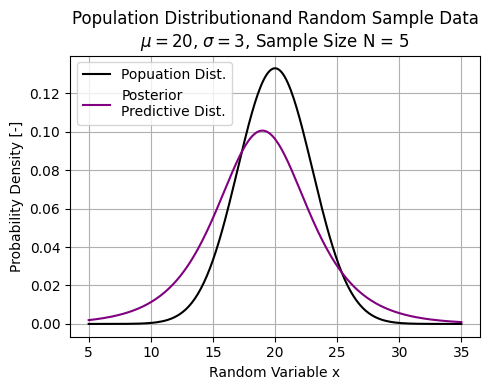

In [117]:
# Plot the population and posterior predictive
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(xvals, pop_dist.pdf(xvals), color='k', label='Popuation Dist.')
ax.plot(xvals, posterior_predictive_distribution, color='purple', label='Posterior\nPredictive Dist.')

ax.set_xlabel('Random Variable x')
ax.set_ylabel('Probability Density [-]')
ax.set_title(f'Population Distribution' +  'and Random Sample Data' + f'\n$\mu = ${mu_true}, $\sigma = ${sigma_true}' + f', Sample Size N = {N}')
ax.grid('enable')
ax.legend(loc='upper left')
fig.tight_layout()

### Appendix: Generating presentation graphs

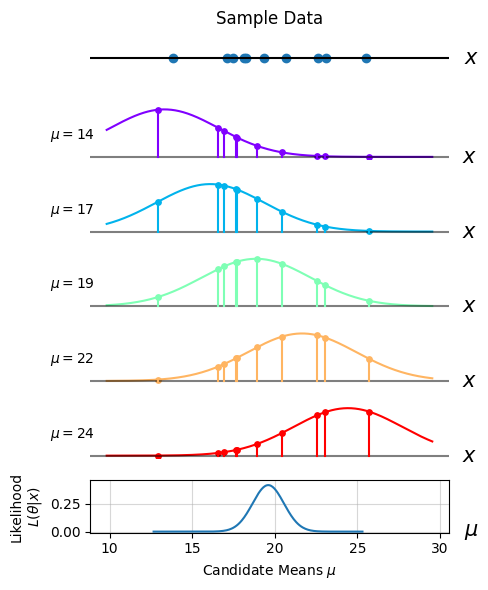

In [118]:
### Likelihood explanatory graph

# Define population
mu_true = 20    # Population mean
sigma_true = 3  # Population standard deviation
pop_dist = sci.stats.norm(mu_true, sigma_true)  # Define a normal distribution with these parameters

# Take a sample
N = 10   # Sample size
rng = np.random.RandomState(seed=25)  # This line is only necessary if you want to control the random number generation seed
sample_data = pop_dist.rvs(N, random_state=rng)

# Calculate some sample statistics and generate a sample distribution with them
sample_mean = np.mean(sample_data)
sample_std = np.sqrt(np.sum((sample_data - sample_mean)**2)/(N-1))
sample_dist = sci.stats.norm(sample_mean, sample_std)  # Define a normal distribution with these parameters

# Calculate the likelihood
# Note that for numerical reasons we do this with the log likelihood and convert back after
log_likelihood = np.zeros_like(mu_vector)
for idx, m in enumerate(mu_vector):
    probability_i = sci.stats.norm.pdf(sample_data, loc=m, scale=sigma_true)
    log_likelihood[idx] = np.sum(np.log(probability_i))

# Convert back to likelihod form log-likelihood
likelihood = np.exp(log_likelihood - np.max(log_likelihood) + 100)
likelihood /= sci.integrate.trapz(likelihood, mu_vector) # Normalize for plotting purposes

# Plot the liklihood calcultion example
L = 500  # Length of the xvals array
xvals = np.linspace(mu_true - 3*sigma_true, mu_true + 3*sigma_true, L)
xlims = np.array([-1, 1])*5 + [np.min(sample_data), np.max(sample_data)]

fig, ax = plt.subplots(7, 1, figsize=(5, 6))
p = 0
ax[p].scatter(sample_data, 0*sample_data)
ax[p].axhline(0, color='k')
ax[p].axis('off')
ax[p].text(1.03*np.max(xlims), 0, '$x$', size=15, va='center')
ax[p].set_title('Sample Data')
ax[p].set_xlim(xlims)

cmap = plt.get_cmap('rainbow')
for idx, m in enumerate(mu_vector[30::50]):
    p += 1
    c = cmap(int(255*idx/(len(mu_vector[30::50])-1)))
    dist_i = sci.stats.norm(m, sigma_true)
    ax[p].plot(xvals, dist_i.pdf(xvals), color=c)
    ax[p].axhline(0, color='k', alpha=0.5)
    ax[p].text(1.005*np.max(xlims), 0, '$x$', size=15, va='center')
    ax[p].scatter(sample_data, dist_i.pdf(sample_data), 15, color=c)
    for xi in sample_data:
        ax[p].plot([xi, xi],[0, dist_i.pdf(xi)], color=c)
    ax[p].axis('off')
    ax[p].text(xlims[0]-1, 0.05, f'$\mu = ${m:.0f}')
    ax[p].grid('enable')

# Plot liklihood
p += 1
ax[p].plot(mu_vector, likelihood)
ax[p].text(1.03*np.max(xlims), 0, '$\mu$', size=15, va='center')
ax[p].set_ylabel('Likelihood\n' + r'$L(\theta|x)$')
ax[p].set_xlabel('Candidate Means $\mu$')
ax[p].set_xlim(xlims)
ax[p].set_ylim([-0.01, np.max(likelihood)*1.1])
ax[p].grid('enable', alpha=0.5)

fig.tight_layout()


MAP Mean: 19.0


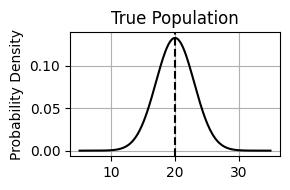

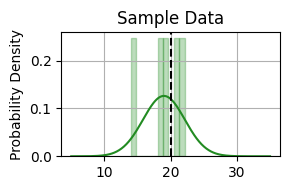

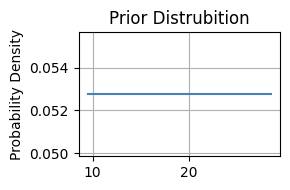

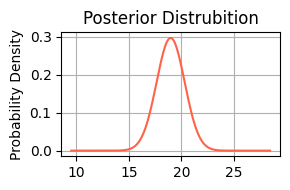

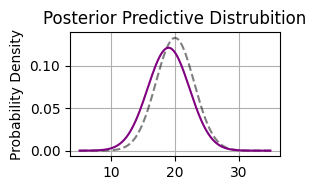

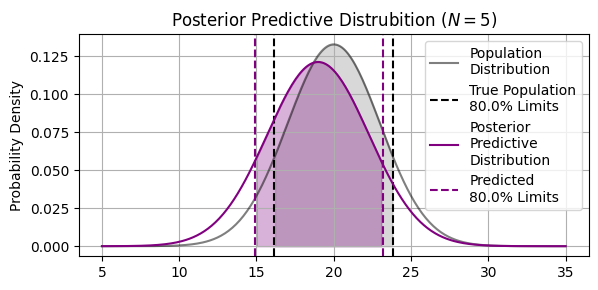

In [125]:
### Posterior Predictive Explanatory Graph

# Define confidence percentage
population_percentage = 0.80
zp = sci.stats.norm(0, 1).ppf(1 - (1-population_percentage)/2)  # 2-sided bound

# Define population
mu_true = 20    # Population mean
sigma_true = 3  # Population standard deviation
pop_dist = sci.stats.norm(mu_true, sigma_true)  # Define a normal distribution with these parameters

# Take a sample
N = 5   # Sample size
rng = np.random.RandomState(seed=968)  # This line is only necessary if you want to control the random number generation seed
sample_data = pop_dist.rvs(N, random_state=rng)

# Calculate some sample statistics and generate a sample distribution with them
sample_mean = np.mean(sample_data)
sample_std = np.sqrt(np.sum((sample_data - sample_mean)**2)/(N-1))
sample_dist = sci.stats.norm(sample_mean, sample_std)  # Define a normal distribution with these parameters

# Plot the population and the sample
L = 250  # Length of the xvals array
xvals = np.linspace(mu_true - 3*sigma_true, mu_true + 3*sigma_true, L)

# Define a vector of the parameters we're searching over
mu_vector = np.linspace(sample_mean - 3*sample_std, sample_mean + 3*sample_std, 2*L)

# Define the prior
prior = np.ones_like(mu_vector)
prior /= sci.integrate.trapz(prior, mu_vector) # Normalize 

# Calculate the likelihood
# Note that for numerical reasons we do this with the log likelihood and convert back after
log_likelihood = np.zeros_like(mu_vector)
for idx, m in enumerate(mu_vector):
    probability_i = sci.stats.norm.pdf(sample_data, loc=m, scale=sigma_true)
    log_likelihood[idx] = np.sum(np.log(probability_i))

# Convert back to likelihod form log-likelihood
likelihood = np.exp(log_likelihood - np.max(log_likelihood) + 100)
likelihood /= sci.integrate.trapz(likelihood, mu_vector) # Normalize for plotting purposes

# Calculate the posterior
posterior = likelihood * prior
posterior /= sci.integrate.trapz(posterior, mu_vector) # Normalize 

# Calculate the peak
max_inds = posterior == np.max(posterior)
map_mean = mu_vector[max_inds][0]
print(f'MAP Mean: {map_mean:.1f}')

# Calculate the posterior predictive distribution
# Using the 3D posterior over mu, sigma plane
d_m = np.mean(np.diff(mu_vector))
xvals_2 = xvals = np.linspace(mu_true - 5*sigma_true, mu_true + 5*sigma_true, L)
posterior_predictive_distribution = np.zeros_like(xvals)
posterior_predictive_distribution_all = np.zeros((len(mu_vector)*len(sigma_vector), L))

idx = 0
for jdx, m in enumerate(mu_vector):
    posterior_predictive_distribution_all[idx, :] = sci.stats.norm(m, sigma_true).pdf(xvals) * posterior[jdx] * d_m
    idx += 1

posterior_predictive_distribution = np.sum(posterior_predictive_distribution_all, axis=0)  # Sum
posterior_predictive_distribution /= np.trapz(posterior_predictive_distribution, xvals)  # Normalize

# Take slices of the posterior predictive to search for the limiting bounds
levels = np.linspace(np.max(posterior_predictive_distribution), 0, 1000)
dx = np.mean(np.diff(xvals))
for idx, l_ in enumerate(levels):
    if l_ == 0:
        prob = 1
    elif l_ == 1:
        prob = 0
    else:
        pred_indices = posterior_predictive_distribution > l_
        prob = np.sum(posterior_predictive_distribution[pred_indices] * dx) # Probability within this iso-contour
    if prob > population_percentage:
        break

# Calculate prediction interval from posterior predictive
pred_lower = np.min(xvals[pred_indices])
pred_upper = np.max(xvals[pred_indices])

# Calculate prediction interval from true population
true_upper = mu_true + zp*sigma_true
true_lower = mu_true - zp*sigma_true

# Plot parameters
Lx = 3
Ly = 2

# Population plot
fig, ax = plt.subplots(figsize=(Lx, Ly))
ax.plot(xvals, pop_dist.pdf(xvals), color='k', label='Population PDF')  # Plot the population pdf
ax.axvline(mu_true, color='k', linestyle='--', label='Population Mean')
ax.set_ylabel('Probability Density')
ax.set_title('True Population')
ax.grid('enable')
# ax.legend()
fig.tight_layout()

# Sample Plot
fig, ax = plt.subplots(figsize=(Lx, Ly))
ax.hist(sample_data, alpha=0.3, edgecolor='forestgreen', color='forestgreen', density=True, label='Sample Histogram')
ax.plot(xvals, sample_dist.pdf(xvals), color='forestgreen', label='Sample PDF')
ax.axvline(mu_true, color='k', linestyle='--', label='Population Mean')
ax.set_ylabel('Probability Density')
ax.set_title('Sample Data')
ax.grid('enable')
# ax.legend()
fig.tight_layout()

# Prior Plot
fig, ax = plt.subplots(figsize=(Lx, Ly))
ax.plot(mu_vector, prior, color='steelblue', label='Sample PDF')
ax.set_ylabel('Probability Density')
ax.set_title('Prior Distrubition')
ax.grid('enable')
# ax.legend()
fig.tight_layout()

# Posterior Plot
fig, ax = plt.subplots(figsize=(Lx, Ly))
ax.plot(mu_vector, posterior, color='tomato', label='Sample PDF')
ax.set_ylabel('Probability Density')
ax.set_title('Posterior Distrubition')
ax.grid('enable')
# ax.legend()
fig.tight_layout()

# Posterior Predictive Plot
fig, ax = plt.subplots(figsize=(Lx, Ly))
# ax.hist(samples, alpha=0.3, edgecolor='forestgreen', color='forestgreen', density=True, label='Sample Histogram')
ax.plot(xvals, pop_dist.pdf(xvals), '--', color='k', alpha=0.5, label='Sample PDF')
ax.plot(xvals, posterior_predictive_distribution, color='purple', label='Sample PDF')
# ax.axvline(mu, color='k', linestyle='--', label='Population Mean')
ax.set_ylabel('Probability Density')
ax.set_title('Posterior Predictive Distrubition')
ax.grid('enable')
# ax.legend()
fig.tight_layout()

# Large Posterior Predictive Plot
fig, ax = plt.subplots(figsize=(6, 3))
# ax.hist(samples, alpha=0.3, edgecolor='forestgreen', color='forestgreen', density=True, label='Sample Histogram')
ax.plot(xvals, pop_dist.pdf(xvals), color='k', alpha=0.5, label='Population\nDistribution')
ax.axvline(true_lower, color='k', linestyle='--', label=f'True Population\n{100*population_percentage:.1f}% Limits')
ax.axvline(true_upper, color='k', linestyle='--')
ax.fill_between(xvals[(xvals < true_upper) & (xvals > true_lower)], pop_dist.pdf(xvals)[(xvals < true_upper) & (xvals > true_lower)], color='0.5', alpha=0.3)

ax.plot(xvals, posterior_predictive_distribution, color='purple', label='Posterior\nPredictive\nDistribution')
ax.axvline(pred_lower, color='purple', linestyle='--', label=f'Predicted\n{100*population_percentage:.1f}% Limits')
ax.axvline(pred_upper, color='purple', linestyle='--')
ax.fill_between(xvals[(xvals < pred_upper) & (xvals > pred_lower)], posterior_predictive_distribution[(xvals < pred_upper) & (xvals > pred_lower)], color='purple', alpha=0.3)

ax.set_ylabel('Probability Density')
ax.set_title(f'Posterior Predictive Distrubition ($N=${N})')
ax.grid('enable')
ax.legend()
fig.tight_layout()